In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import normflows as nf
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
from fab import FABModel, HamiltonianMonteCarlo, Metropolis
from fab.utils.logging import ListLogger
from fab.utils.plotting import plot_history, plot_contours, plot_marginal_pair
from fab.target_distributions.gmm import GMM
from fab.utils.prioritised_replay_buffer import SimpleBuffer
from torch.autograd import grad
from fab.utils.plotting import plot_contours, plot_marginal_pair
from experiments.make_flow import make_wrapped_normflow_realnvp
import importlib 
import models.ddpm
import models.mlp
import pdb
from tqdm import tqdm
from models.ddpm import GaussianDiffusion, TMLP
from models.mlp import MyMLP, SpectralNormMLP

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

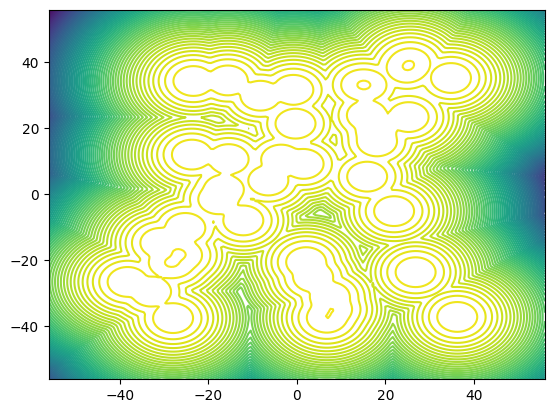

In [4]:
dim = 2
n_mixes = 40
loc_scaling = 40.0  # scale of the problem (changes how far apart the modes of each Guassian component will be)
log_var_scaling = 1.0 # variance of each Gaussian
seed = 0

torch.manual_seed(0)  # seed of 0 for GMM problem
target = GMM(dim=dim, n_mixes=n_mixes,
              loc_scaling=loc_scaling, log_var_scaling=log_var_scaling,
              use_gpu=True, true_expectation_estimation_n_samples=int(1e5))
# plot target
target.to("cpu")
fig, ax = plt.subplots()
plotting_bounds = (-loc_scaling * 1.4, loc_scaling * 1.4)
plot_contours(target.log_prob, bounds=plotting_bounds, n_contour_levels=80, ax=ax, grid_width_n_points=200)
target.to("cuda")

In [5]:
# hyper-parameters

# Flow
n_flow_layers = 15
layer_nodes_per_dim = 40
lr = 1e-4
max_gradient_norm = 100.0
batch_size = 128
n_iterations = 4000
n_eval = 10
eval_batch_size = batch_size * 10
n_plots = 10 # number of plots shows throughout tranining
use_64_bit = True
alpha = 2.0
num_samples = 10000

flow = make_wrapped_normflow_realnvp(dim, n_flow_layers=n_flow_layers, 
                                 layer_nodes_per_dim=layer_nodes_per_dim,
                                act_norm = False)

/mnt/user_storage/active/lib/python3.9/site-packages/torch/_tensor.py:738: UserWarning: torch.lu is deprecated in favor of torch.linalg.lu_factor / torch.linalg.lu_factor_ex and will be removed in a future PyTorch release.
LU, pivots = torch.lu(A, compute_pivots)
should be replaced with
LU, pivots = torch.linalg.lu_factor(A, compute_pivots)
and
LU, pivots, info = torch.lu(A, compute_pivots, get_infos=True)
should be replaced with
LU, pivots, info = torch.linalg.lu_factor_ex(A, compute_pivots) (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1992.)
  LU, pivots, infos = torch._lu_with_info(


In [6]:
def plot_dataset(samples, gen_samples=None):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    target.to("cpu")
    plot_contours(target.log_prob, bounds=plotting_bounds, ax=axs[0], n_contour_levels=50, grid_width_n_points=200)
    
    # plot dataset samples
    plot_marginal_pair(samples, ax=axs[0], bounds=plotting_bounds)
    axs[0].set_title("Dataset samples")

    if gen_samples is not None:
        plot_contours(target.log_prob, bounds=plotting_bounds, ax=axs[1], n_contour_levels=50, grid_width_n_points=200)
        # plot generated samples
        plot_marginal_pair(gen_samples, ax=axs[1], bounds=plotting_bounds)
        axs[1].set_title("Generated samples")

    else:
        #delete subplot
        fig.delaxes(axs[1])
    target.to("cuda")
    plt.show()
    return [fig]


In [7]:
def normalize(x):
    '''
        normalizes to [-1, 1]
    '''
    mins = -50 #torch.min(x, dim=0)[0]
    maxs = 50 #torch.max(x, dim=0)[0]
    ## [ 0, 1 ]
    x = (x - mins) / (maxs - mins + 1e-5)
    ## [ -1, 1 ]
    x = x * 2 - 1
    
    return x, mins, maxs

def unnormalize(x, mins, maxs):
    '''
        x : [ -1, 1 ]
    '''
    assert x.max() <= 1 and x.min() >= -1, f'x range: ({x.min():.4f}, {x.max():.4f})'
    #x = x * std + mean
    x = (x + 1) / 2
    return x * (maxs - mins) + mins

### Dataset

In [8]:
# normalize the dataset
init_num_samples = 2048
#unnorm_init_samples = target.sample(torch.tensor(init_num_samples).unsqueeze(0)).to(device).detach()
unnorm_init_samples = flow.sample((init_num_samples,)).to(device).detach()
init_energy = target.log_prob(unnorm_init_samples).detach()
init_samples, global_mins_init, global_maxs_init = normalize(unnorm_init_samples)

global_mins_init = -50
global_maxs_init = 50

init_dataset = TensorDataset(init_samples, init_energy)
init_loader = DataLoader(init_dataset, batch_size = 512, shuffle=True) 

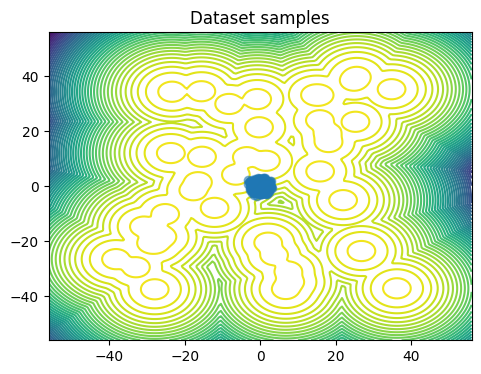

In [9]:
plot_dataset(unnorm_init_samples) # visualise the initial samples
plt.show()

### Networks

In [10]:
model = MyMLP().to(device)
reward_model = SpectralNormMLP().to(device)

diffusion = GaussianDiffusion(
    model,
    image_size = 2,
    timesteps = 1000,          # number of steps
    auto_normalize= False      # data is already normalized, output will be in range [-1, 1]
).to(device)

In [11]:
opt_diffusion = Adam(diffusion.parameters())

In [12]:
buffer = SimpleBuffer(2, 5000, 1000, initial_sampler=None, 
                      device=device, fill_buffer_during_init=False, sample_with_replacement=True)
buffer.add(init_samples, init_energy)

Buffer not initialised, expected that checkpoint will be loaded.


### Training Loop

In [13]:
def train_reward_model(reward_model, trainloader, n_epochs=100):
    opt_reward = Adam(reward_model.parameters())
    
    for epoch in range(n_epochs):
        for samples, gt_energy in trainloader:

            samples = samples.to(device)
            gt_energy = gt_energy.to(device)

            pred_energy = reward_model(samples)
            loss = torch.mean((pred_energy - gt_energy)**2)

            opt_reward.zero_grad()
            loss.backward()
            opt_reward.step()
            
    return reward_model

  0%|          | 0/10 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

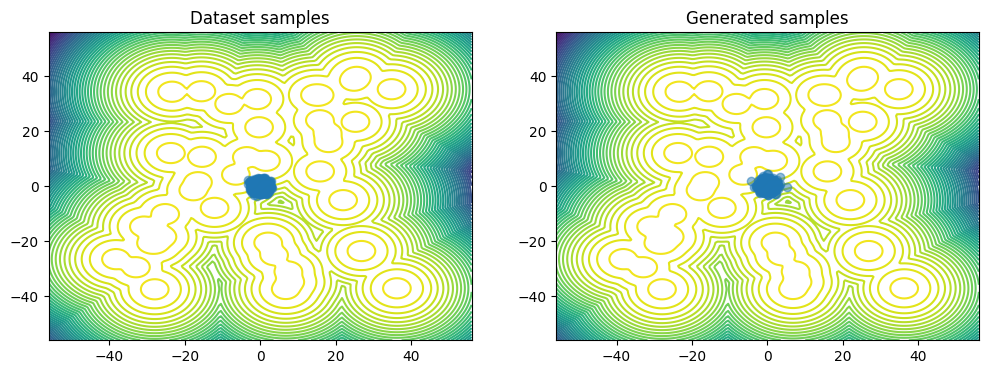

/mnt/user_storage/active/lib/python3.9/site-packages/torch/distributions/distribution.py:179: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn(
 10%|█         | 1/10 [00:09<01:28,  9.82s/it]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

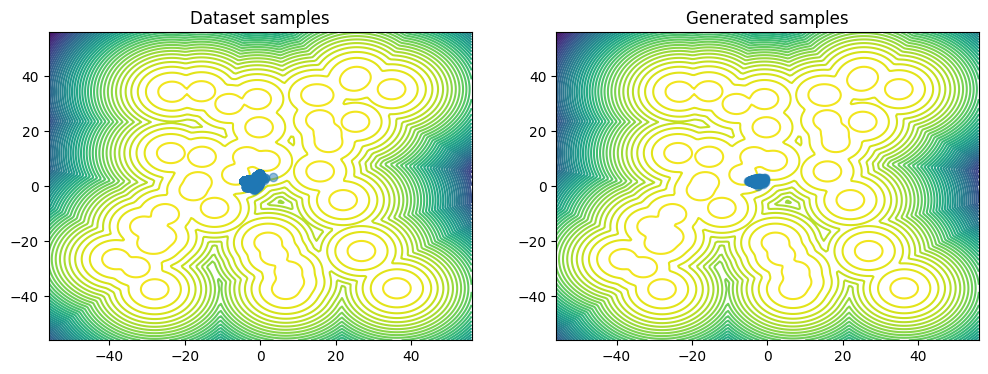

 20%|██        | 2/10 [00:29<02:06, 15.82s/it]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

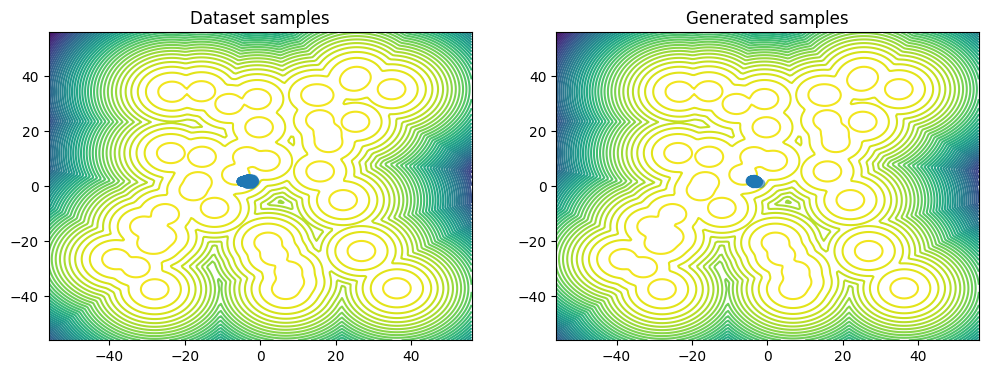

 30%|███       | 3/10 [00:49<02:04, 17.78s/it]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

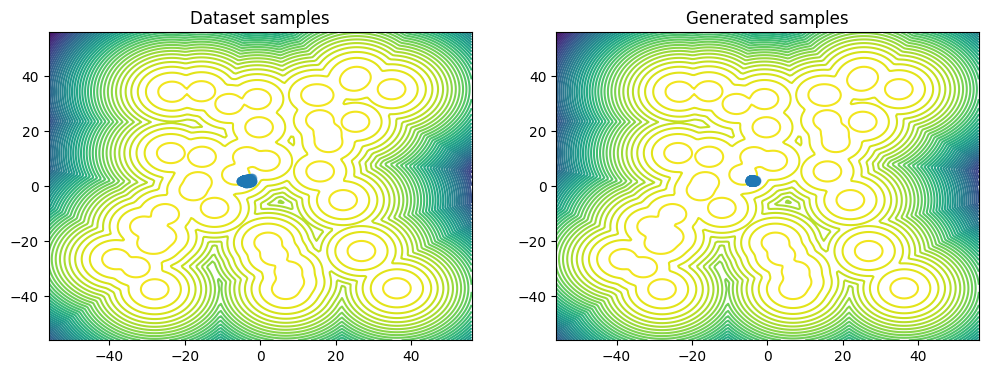

 40%|████      | 4/10 [01:10<01:53, 18.90s/it]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

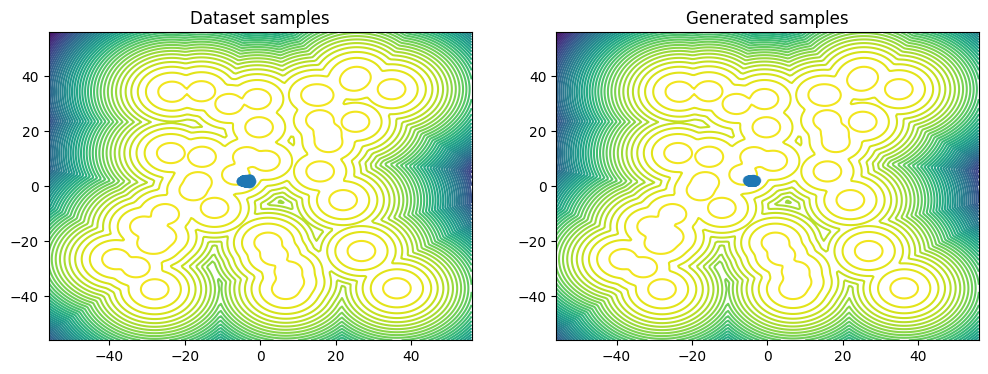

 50%|█████     | 5/10 [01:30<01:36, 19.39s/it]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

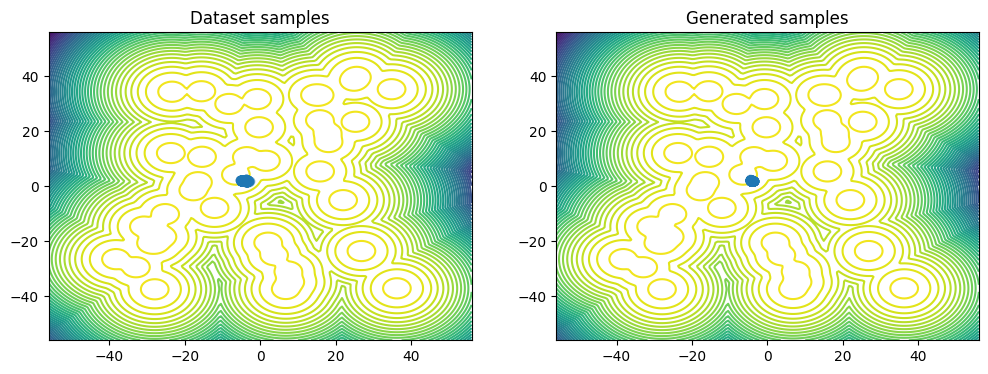

 60%|██████    | 6/10 [01:51<01:18, 19.68s/it]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

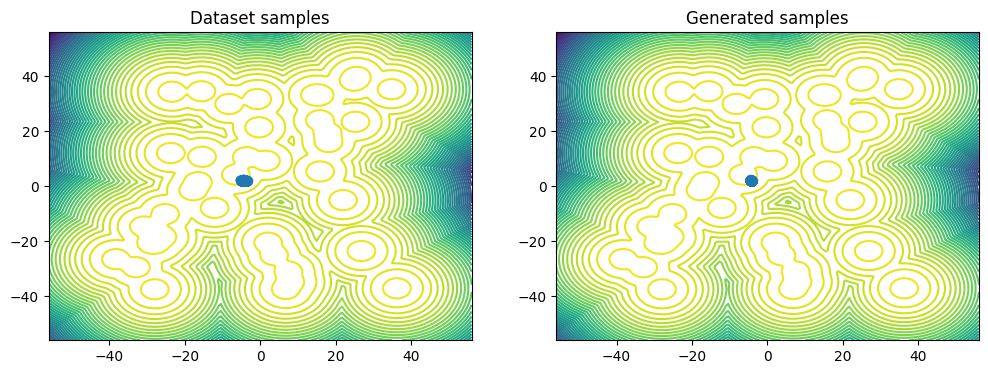

 70%|███████   | 7/10 [02:11<00:59, 19.84s/it]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

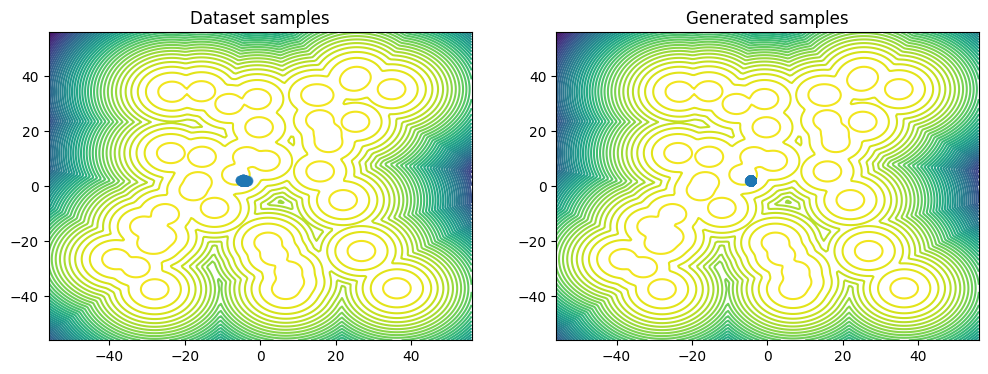

 80%|████████  | 8/10 [02:30<00:39, 19.81s/it]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

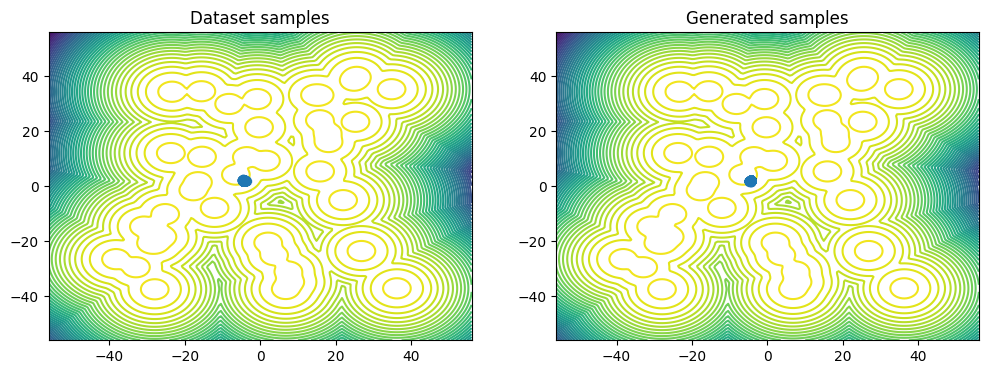

 90%|█████████ | 9/10 [02:50<00:19, 19.84s/it]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

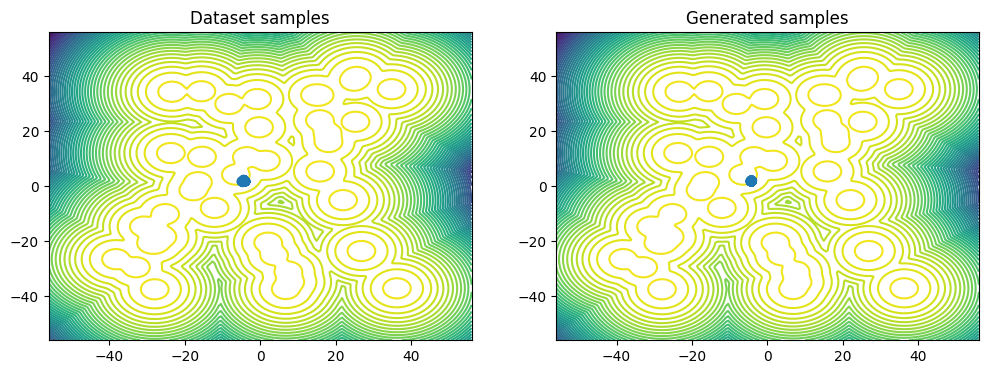

100%|██████████| 10/10 [03:11<00:00, 19.10s/it]


In [14]:
outer_epochs = 10
inner_epochs = 200
reward_epochs = 1 #300

num_samples = 2048

train_dataset = TensorDataset(init_samples.clone(), init_energy.clone())
trainloader = DataLoader(train_dataset, batch_size = 512, shuffle=True) 
global_mins, global_maxs = global_mins_init, global_maxs_init

# Outer Loop
for epoch in tqdm(range(outer_epochs)):
    diffusion = GaussianDiffusion(
    model,
    image_size = 2,
    timesteps = 1000,          # number of steps
    auto_normalize= False      # data is already normalized, output will be in range [-1, 1]
    ).to(device)

    opt_diffusion = Adam(diffusion.parameters())

    # Reward classifier training
    reward_model = train_reward_model(reward_model, trainloader, n_epochs=reward_epochs)
    
    # Inner Loop to trin the diffusion model
    for epoch in range(inner_epochs):
        total_loss = 0.
        for samples,_ in trainloader:
            samples = samples.to(device)
            opt_diffusion.zero_grad()
            loss = diffusion(samples)    
            total_loss += loss.item()
            loss.backward()
            opt_diffusion.step()

    def guidance_fn(x, t):
        with torch.enable_grad():
            x.requires_grad = True
            x = x.clamp(-1., 1.)
            x = unnormalize(x, global_mins, global_maxs)
            return -0.9 * grad(target.log_prob(x).sum(), x, create_graph=True)[0]
            # return -0.05 * grad(reward_model(x).sum(), x, create_graph=True)[0]

    # Resample with guidance
    samples = diffusion.sample(num_samples, cond_fn=guidance_fn).to(device).detach()
    samples_energy = target.log_prob(unnormalize(samples, global_mins, global_maxs)).detach()

    # Update Buffer 
    buffer.add(samples, samples_energy)

    plot_dataset(unnormalize(train_dataset.tensors[0], global_mins, global_maxs), 
                 unnormalize(samples, global_mins, global_maxs))
    plt.show()
    # Resample data from the buffer
    samples, samples_energy, _ = buffer.sample(512 * 10)
    train_dataset = TensorDataset(samples, samples_energy)
    trainloader = DataLoader(train_dataset, batch_size = 512, shuffle=True)

### Sampling